# import Libraries

In [2]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
'''------------------------Models libraries-------------------------'''
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# Where is Data?
* Shenzhen dataset: 566 images & masks
* Montgomery dataset: 138 images & masks

In [3]:
image_path = os.path.join("../input/chest-xray-masks-and-labels/Lung Segmentation/", "CXR_png")
mask_path = os.path.join("../input/chest-xray-masks-and-labels/Lung Segmentation/","masks/")

# Load names for proper import  

In [4]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [5]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


* Shenzhen in train set
* Montgomery in test set
* concate later

In [6]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

# Function for loading images

In [7]:
def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    shape = (X_shape, X_shape)
    # X_shape = image_size
    if flag == "test":
        for i in tqdm(testing_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path, i))
            im = cv2.resize(im, shape)[:, :, 0]
            
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path, i))
            mask = cv2.resize(mask, shape)[:, :, 0]
            
            im_array.append(im)
            mask_array.append(mask)
    
    if flag == "train":
        for i in tqdm(training_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path, i.split("_mask")[0] + ".png"))
            im = cv2.resize(im, shape)[:, :, 0]
            
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path, i + ".png"))
            mask = cv2.resize(mask, shape)[:, :, 0]
            
            im_array.append(im)
            mask_array.append(mask)
    # return list
    return im_array, mask_array

In [39]:
dim = 512
X_train, y_train = getData(dim, flag = "train")
X_test, y_test = getData(dim)

100%|██████████| 138/138 [00:59<00:00,  2.30it/s]


# Change list to numpy array
### add an extra dimensions
* (512, 512) ---> (512, 512, 1)

In [40]:
X_train = np.array(X_train).reshape(len(X_train), dim, dim, 1)
y_train = np.array(y_train).reshape(len(y_train), dim, dim, 1)
X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)
y_test = np.array(y_test).reshape(len(y_test), dim, dim, 1)

In [41]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(566, 512, 512, 1) (566, 512, 512, 1)
(138, 512, 512, 1) (138, 512, 512, 1)


# Loading Check
### everything works?

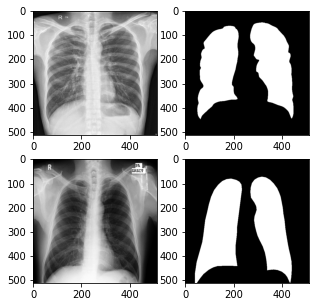

In [42]:
i = 100
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
axs[0, 0].imshow(X_train[i], cmap='gray')
axs[0, 1].imshow(y_train[i], cmap='gray')
axs[1, 0].imshow(X_test[i], cmap='gray')
axs[1, 1].imshow(y_test[i], cmap='gray');

In [47]:
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train, X_test), axis=0)
masks  = np.concatenate((y_train, y_test), axis=0)

In [14]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [69]:
metrics = [dice_coef, 'binary_accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall()]

In [70]:
model = unet(input_size=(512, 512, 1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=metrics)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 512, 512, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 512, 512, 32) 9248        conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 256, 256, 32) 0           conv2d_58[0][0]                  
____________________________________________________________________________________________

In [71]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [72]:
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [73]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

In [64]:
# del loss_history

In [ ]:
# a = (images-127.0)/127.0
# b = (masks>127).astype(np.float32)

In [60]:
X_train, X_val, Y_train, Y_val = train_test_split((images-127.0)/127.0, 
                                                  (masks>127).astype(np.float32), 
                                                  test_size = 0.1, 
                                                  random_state = 2018)

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, 
                                                    test_size = 0.1, 
                                                    random_state = 2018)

In [74]:
model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = metrics)

In [75]:
loss_history = model.fit(X_train, Y_train,
                         batch_size = 16, epochs = 50,
                         validation_data = (X_val, Y_val),
                         callbacks=callbacks_list)

# clear_output()

Epoch 1/50
36/36 [==============================] - 21s 545ms/step - loss: -0.3553 - dice_coef: 0.3554 - binary_accuracy: 0.6719 - precision_1: 0.4279 - recall: 0.6040 - val_loss: -0.4647 - val_dice_coef: 0.4652 - val_binary_accuracy: 0.6298 - val_precision_1: 0.3856 - val_recall: 0.8474

Epoch 00001: val_loss improved from inf to -0.46468, saving model to cxr_reg_weights.best.hdf5
Epoch 2/50
36/36 [==============================] - 19s 519ms/step - loss: -0.5221 - dice_coef: 0.5222 - binary_accuracy: 0.6717 - precision_1: 0.4273 - recall: 0.8559 - val_loss: -0.6250 - val_dice_coef: 0.6235 - val_binary_accuracy: 0.7343 - val_precision_1: 0.4791 - val_recall: 0.8992

Epoch 00002: val_loss improved from -0.46468 to -0.62496, saving model to cxr_reg_weights.best.hdf5
Epoch 3/50
36/36 [==============================] - 19s 520ms/step - loss: -0.7044 - dice_coef: 0.7045 - binary_accuracy: 0.8172 - precision_1: 0.6033 - recall: 0.8377 - val_loss: -0.8392 - val_dice_coef: 0.8410 - val_binary_

In [39]:

# train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
#                                                             (mask>127).astype(np.float32), 
#                                                             test_size = 0.1,random_state = 2018)

# train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
#                                                             test_size = 0.1, 
#                                                             random_state = 2018)

# loss_history = model.fit(x = train_vol,
#                        y = train_seg,
#                          batch_size = 16,
#                   epochs = 50,
#                   validation_data =(test_vol,test_seg) ,
#                   callbacks=callbacks_list)


# clear_output()

TypeError: unsupported operand type(s) for -: 'list' and 'float'

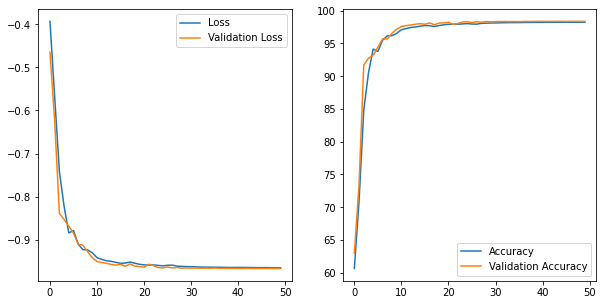

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100 * np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

In [77]:
pred_candidates = np.random.randint(1, X_test.shape[0], 10)
preds = model.predict(X_test)

In [79]:
preds = model.predict(X_test)
preds.max()

1.0

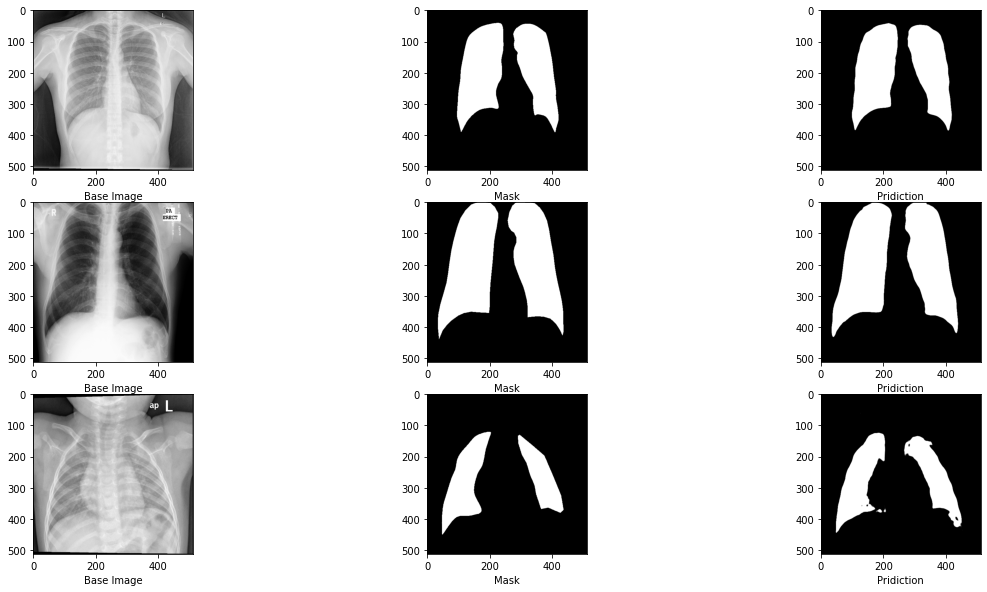

In [80]:
plt.figure(figsize=(20, 10))

for i in range(0, 9, 3):
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(np.squeeze(X_test[pred_candidates[i]]), cmap='gray')
    plt.xlabel("Base Image")
    
    
    plt.subplot(3, 3, i + 2)
    plt.imshow(np.squeeze(Y_test[pred_candidates[i]]), cmap='gray')
    plt.xlabel("Mask")
    
    plt.subplot(3, 3, i + 3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]), cmap='gray')
    plt.xlabel("Pridiction")

In [81]:
model.evaluate(X_test, Y_test)

2/2 [==============================] - 1s 287ms/step - loss: -0.9675 - dice_coef: 0.9675 - binary_accuracy: 0.9833 - precision_1: 0.9723 - recall: 0.9628


[-0.9674789905548096,
 0.9674789905548096,
 0.9833336472511292,
 0.972325325012207,
 0.9627878069877625]